# Importing library

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import os
import cv2

In [3]:
tf.keras.backend.clear_session()

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
data_path = 'image_dataset'

x,y = [],[]

class_names = os.listdir(data_path)

print(class_names)

['battery', 'clothing_waste', 'glass', 'metal', 'organic', 'paper', 'plastic']


## Function for padding and resizing image

In [6]:
def resize_image(img):
    return cv2.resize(img, (224,224), interpolation=cv2.INTER_LANCZOS4)

def pad_image(img):
    height, width = img.shape[:2]

    height_padding = (224 - height % 224) % 224
    width_padding = (224 - width % 224) % 224

    top_padding = height_padding // 2
    bottom_padding = height_padding - top_padding
    left_padding = width_padding // 2
    right_padding = width_padding - left_padding

    padded_img = cv2.copyMakeBorder(
        img, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0]
    )

    return padded_img

# Load the image from the dataset

In [7]:
for index, class_path in enumerate(class_names):
    for image in os.listdir(os.path.join(data_path, class_path)):
        
        img = cv2.imread(os.path.join(data_path, class_path, image))

        padded_img = pad_image(img)
        resized_img = resize_image(padded_img)

        rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
        
        x.append(rgb_img)
        y.append(index)

In [8]:
x,y = np.array(x), np.array(y)

# The Image count of each category

In [9]:
unique, counts = np.unique(y, return_counts=True)
category_counts = dict(zip(class_names, counts))

for category, count in category_counts.items():
    print(f"{category}: {count}")

battery: 945
clothing_waste: 970
glass: 1000
metal: 999
organic: 985
paper: 1105
plastic: 941


# Sample image

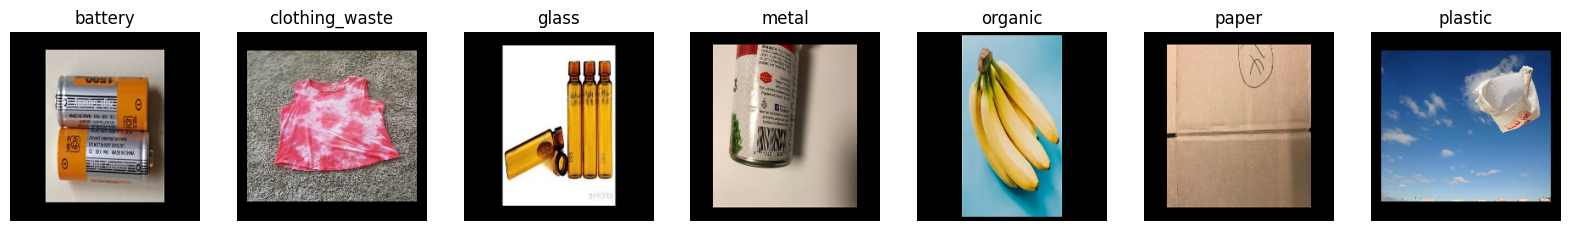

In [10]:
fig, axes = plt.subplots(1, len(class_names), figsize=(20, 5))

for i, class_name in enumerate(class_names):
    class_index = class_names.index(class_name)
    image_index = np.where(y == class_index)[0][0]
    axes[i].imshow(x[image_index])
    axes[i].set_title(class_name)
    axes[i].axis('off')

plt.show()

# Splitting data into training and testing

80% for training, 10% for validation and 10% for testing

In [11]:
x_train,x_temp,y_train,y_temp = train_test_split(x,y,test_size=0.2,stratify=y,random_state=42)

x_val,x_test,y_val,y_test = train_test_split(x_temp,y_temp,test_size=0.5,stratify=y_temp,random_state=42)

In [12]:
x_train.shape

(5556, 224, 224, 3)

# Data augmentation

In [13]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(

    rotation_range=20,

    width_shift_range=0.14,

    height_shift_range=0.14,

    horizontal_flip=True,

    zoom_range=0.11,

    brightness_range=[0.9,1.1],

    shear_range=0.12,

    channel_shift_range=0.1,

)

In [14]:
x_train = data_generator.flow(x_train, y_train,batch_size=len(x_train))

In [15]:
x_train, y_train = next(x_train)

In [16]:
x_train.shape

(5556, 224, 224, 3)

Edge detection is applied to the image

In [17]:
def canny_edge_detection(img):
    t_lower=100
    t_upper=200
    l2_gradient=True

    img = img.astype(np.uint8)
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    edge = cv2.Canny(gray_img, t_lower, t_upper, L2gradient=l2_gradient)
    return edge

In [18]:
x_train = np.array([canny_edge_detection(img) for img in x_train])
x_test = np.array([canny_edge_detection(img) for img in x_test])
x_val= np.array([canny_edge_detection(img) for img in x_val])

# Normalizing to 0 - 1

In [19]:
x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0
x_val = x_val.astype("float32")/255.0

In [ ]:
xx_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32) 

In [20]:
x_train.shape

(5556, 224, 224)

In [21]:
class_length = len(class_names)

# Building the model

In [22]:
resnet_model = tf.keras.applications.ResNet50(
      include_top=False,
      weights="imagenet",
      input_shape=(224, 224,3),
      pooling = "avg"
    )

model = Sequential([
    tf.keras.layers.InputLayer(input_shape=(224,224,1)),
    tf.keras.layers.Conv2D(3, (3,3), activation='relu', padding='same'),
    resnet_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(class_length,activation='softmax')

])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

In [24]:
tf.keras.backend.clear_session()

In [25]:
from tensorflow.keras import mixed_precision 
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU, compute capability 8.6


In [26]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [28]:
history = model.fit(x_train,y_train,epochs=10,validation_data=(x_val,y_val), batch_size = 2,callbacks=[early_stopping])

Epoch 1/10
2778/2778 [==============================] - ETA: 0s - loss: 2.3577 - accuracy: 0.1497

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
model.save("ResNet50_Waste.h5")

In [ ]:
loss,accuracy = model.evaluate(x_test,y_test)

print("Accuracy: " + str(accuracy*100) + "%")